In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os

In [25]:
import shutil
import random

def split_data(SOURCE, TRAINING, VALIDATION, TEST, SPLIT_SIZE):
    all_files = os.listdir(SOURCE)
    random.shuffle(all_files)
    total = len(all_files)
    train_end = int(SPLIT_SIZE[0] * total)
    val_end = train_end + int(SPLIT_SIZE[1] * total)

    for i, file_name in enumerate(all_files):
        if i < train_end:
            shutil.copy(os.path.join(SOURCE, file_name), os.path.join(TRAINING, file_name))
        elif i < val_end:
            shutil.copy(os.path.join(SOURCE, file_name), os.path.join(VALIDATION, file_name))
        else:
            shutil.copy(os.path.join(SOURCE, file_name), os.path.join(TEST, file_name))

# Example usage:
# Assume your original data is in 'dataset/original/men' and 'dataset/original/women'
# and you want to split them into 'train', 'validation', 'test'

def prepare_data():
    categories = ['men', 'women']
    for category in categories:
        SOURCE = f'dataset/original/{category}'
        TRAINING = f'dataset/train/{category}'
        VALIDATION = f'dataset/validation/{category}'
        TEST = f'dataset/test/{category}'

        # Create directories if they don't exist
        os.makedirs(TRAINING, exist_ok=True)
        os.makedirs(VALIDATION, exist_ok=True)
        os.makedirs(TEST, exist_ok=True)

        split_data(SOURCE, TRAINING, VALIDATION, TEST, SPLIT_SIZE=(0.7, 0.15, 0.15))


prepare_data()


In [26]:
IMG_HEIGHT, IMG_WIDTH = 224, 224  # MobileNetV2 expects at least 96x96, 224x224 is standard
BATCH_SIZE = 32

In [27]:
# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation data should not be augmented, only rescaled
validation_datagen = ImageDataGenerator(rescale=1./255)

# Test data should not be augmented, only rescaled
test_datagen = ImageDataGenerator(rescale=1./255)


In [28]:
# Paths to your dataset directories
train_dir = 'dataset/train'
validation_dir = 'dataset/validation'
test_dir = 'dataset/test'

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Binary classification
)

# Validation generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Important for evaluation
)


Found 1614 images belonging to 2 classes.
Found 345 images belonging to 2 classes.
Found 348 images belonging to 2 classes.


In [29]:
# Load the MobileNetV2 model, excluding the top classification layers
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the base model to prevent its weights from being updated during training
base_model.trainable = False


In [30]:
# Create the model
# Define the input shape explicitly for the first layer
model = models.Sequential([
    layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)), # Add this line to define input shape
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Display the model architecture
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [31]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [32]:
# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Added .keras extension to the filepath
checkpoint = ModelCheckpoint('gender_classification_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max')

In [33]:
# Check train_generator output
for data, labels in train_generator:
    print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")
    break  # Print only the first batch

# Check validation_generator output
for data, labels in validation_generator:
    print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")
    break  # Print only the first batch

Data shape: (32, 224, 224, 3), Labels shape: (32,)
Data shape: (32, 224, 224, 3), Labels shape: (32,)


In [34]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=30,  # You can adjust this based on when the model converges
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.5795 - loss: 0.7043 - val_accuracy: 0.7312 - val_loss: 0.5063
Epoch 2/30
 1/50 ━━━━━━━━━━━━━━━━━━━━ 1:28 2s/step - accuracy: 0.7812 - loss: 0.4718

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 371ms/step - accuracy: 0.7812 - loss: 0.4718 - val_accuracy: 0.7200 - val_loss: 0.4738
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.8066 - loss: 0.4486 - val_accuracy: 0.7781 - val_loss: 0.4271
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8438 - loss: 0.3953 - val_accuracy: 0.8400 - val_loss: 0.3743
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.8210 - loss: 0.3886 - val_accuracy: 0.8031 - val_loss: 0.3897
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8750 - loss: 0.3241 - val_accuracy: 0.8800 - val_loss: 0.4078
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.8509 - loss: 0.3738 - val_accuracy: 0.8031 - val_loss: 0.3836
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.8125 - loss: 0.3922 - val_accuracy: 0.8400 - val_loss: 0.3769
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.8759 - loss: 0.3185 - val_accuracy: 0.8250 - val_loss: 

In [35]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)


# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.save('gender_classification_model.keras')


In [36]:
model.save('gender_classification_model.keras')  # Save the model

# When loading:
best_model = load_model('gender_classification_model.keras')
best_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,750,277 (10.49 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,196 (1.25 MB)

In [37]:
# Load the best saved model
from tensorflow.keras.models import load_model

best_model = load_model('gender_classification_model.keras')

# Evaluate on test data
test_loss, test_acc = best_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.2145 - loss: 1.1187
Test Accuracy: 49.71%


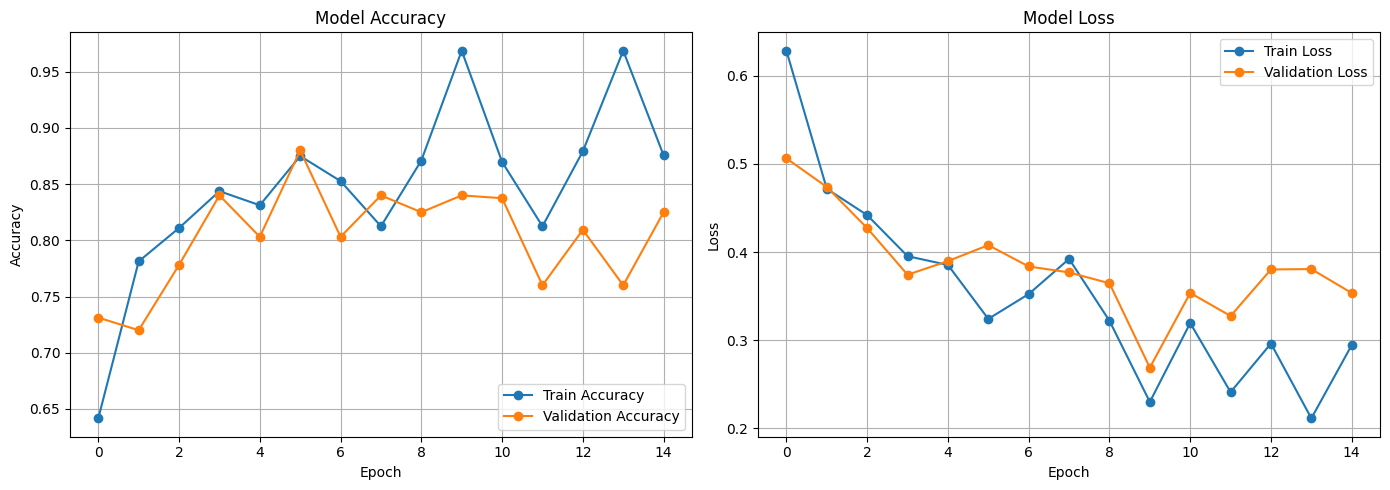

In [38]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


In [39]:
# Unfreeze the base model
base_model.trainable = True

# It's recommended to recompile the model after making changes to the `trainable` property
model.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [40]:
# Redefine callbacks if necessary
early_stop_fine = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_fine = ModelCheckpoint('gender_classification_model_fine_tuned.keras',
                                 monitor='val_accuracy',
                                 save_best_only=True,
                                 mode='max')


In [41]:
# Continue training the model
fine_tune_epochs = 10
total_epochs = len(history.history['loss']) + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stop_fine, checkpoint_fine]
)

Epoch 15/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.5472 - loss: 0.7219 - val_accuracy: 0.5281 - val_loss: 0.7043
Epoch 16/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5312 - loss: 0.6867 - val_accuracy: 0.3600 - val_loss: 0.7814
Epoch 17/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.5850 - loss: 0.6582 - val_accuracy: 0.6250 - val_loss: 0.6575
Epoch 18/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6875 - loss: 0.6504 - val_accuracy: 0.4800 - val_loss: 0.7434
Epoch 19/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.7045 - loss: 0.6055 - val_accuracy: 0.6906 - val_loss: 0.6262
Epoch 20/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7500 - loss: 0.5461 - val_accuracy: 0.6000 - val_loss: 0.6469
Epoch 21/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.7588 - loss: 0.5665 - val_accuracy: 0.7250 - val_loss: 0.5906
Epoch 22/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.8125 - loss: 0.5526 - val_accuracy: 0.

In [42]:
# Load the fine-tuned best model
fine_tuned_model = load_model('gender_classification_model_fine_tuned.keras')

# Evaluate on test data
test_loss_fine, test_acc_fine = fine_tuned_model.evaluate(test_generator)
print(f"Fine-Tuned Test Accuracy: {test_acc_fine * 100:.2f}%")


11/11 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.7259 - loss: 0.5673
Fine-Tuned Test Accuracy: 78.74%


In [43]:
from tensorflow.keras.preprocessing import image

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Rescale
    img_array = np.expand_dims(img_array, axis=0)  # Create batch axis
    return img_array


In [50]:
def predict_gender(img_path, model):
    img = load_and_preprocess_image(img_path)
    prediction = model.predict(img)
    if prediction[0][0] > 0.5:
        return 'Woman'  # Assuming class 1 is women
    else:
        return 'Man'    # Assuming class 0 is men

# Example usage:
prediction = predict_gender('/content/pexels-moose-photos-170195-1036623.jpg', best_model)
print(f"The predicted gender is: {prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
The predicted gender is: Woman
